# Prediciting House Sales Prices

In [73]:
# import the libraries and open the files 

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

houses = pd.read_csv('AmesHousing.tsv', delimiter = '\t')
houses.head(5)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [74]:
# create the functions we'll need

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

def transform_features(df):
    return df

def select_features(df):
    return df[['Gr Liv Area','SalePrice']]

def train_and_test(df):
    train = df.iloc[:1460]
    test = df.iloc[1460:]
    numeric_df = df.select_dtypes(include=numerics)
    features = numeric_df.columns.drop('SalePrice')
    target = ['SalePrice']
    lr = LinearRegression()
    lr.fit(train[features], train[target])
    test_predictions = lr.predict(test[features])
    test_mse = mean_squared_error(test_predictions, test[target])
    return np.sqrt(test_mse)

In [75]:
# test functions
transform_df = transform_features(houses)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)
rmse

57088.25161263909

## Feature Engineering

Handle missing values:

All columns:
* Drop any with 5% or more missing values for now.

Text columns:
* Drop any with 1 or more missing values for now.

Numerical columns:
* For columns with missing values, fill in with the most common value in that column

1: All columns: Drop any with 5% or more missing values for now.

In [76]:
perc_missing_values = (houses.isnull().sum()) / len(houses) * 100
clean_values = perc_missing_values[perc_missing_values < 5]
clean_values.sort_values(ascending = False)
clean_df = houses[clean_values.index]

2: Text columns: Drop any with 1 or more missing values for now.

In [77]:
# select text values
missing_text = clean_df.select_dtypes(include=['object'])
# check number of missing text values
missing_text_count = missing_text.isnull().sum().sort_values(ascending = False)
# drop values where count is > 0
missing_text_columns = missing_text_count[missing_text_count > 0].index
clean_df = clean_df.drop(missing_text_columns, axis = 1)

In [78]:
# check that it worked
print(missing_text_columns.sort_values().values)
print(clean_df.columns.sort_values().values)

['Bsmt Cond' 'Bsmt Exposure' 'Bsmt Qual' 'BsmtFin Type 1' 'BsmtFin Type 2'
 'Electrical' 'Mas Vnr Type']
['1st Flr SF' '2nd Flr SF' '3Ssn Porch' 'Bedroom AbvGr' 'Bldg Type'
 'Bsmt Full Bath' 'Bsmt Half Bath' 'Bsmt Unf SF' 'BsmtFin SF 1'
 'BsmtFin SF 2' 'Central Air' 'Condition 1' 'Condition 2' 'Enclosed Porch'
 'Exter Cond' 'Exter Qual' 'Exterior 1st' 'Exterior 2nd' 'Fireplaces'
 'Foundation' 'Full Bath' 'Functional' 'Garage Area' 'Garage Cars'
 'Gr Liv Area' 'Half Bath' 'Heating' 'Heating QC' 'House Style'
 'Kitchen AbvGr' 'Kitchen Qual' 'Land Contour' 'Land Slope' 'Lot Area'
 'Lot Config' 'Lot Shape' 'Low Qual Fin SF' 'MS SubClass' 'MS Zoning'
 'Mas Vnr Area' 'Misc Val' 'Mo Sold' 'Neighborhood' 'Open Porch SF'
 'Order' 'Overall Cond' 'Overall Qual' 'PID' 'Paved Drive' 'Pool Area'
 'Roof Matl' 'Roof Style' 'Sale Condition' 'Sale Type' 'SalePrice'
 'Screen Porch' 'Street' 'TotRms AbvGrd' 'Total Bsmt SF' 'Utilities'
 'Wood Deck SF' 'Year Built' 'Year Remod/Add' 'Yr Sold']


3: Numerical columns: For columns with missing values, fill in with the most common value in that column

In [79]:
# find numerical columns
num_missing = clean_df.select_dtypes(include=numerics).isnull().sum().sort_values(ascending = False)

# replace missing values in numerical columns with mode
cols = num_missing[num_missing > 0].index

for col in cols: 
    clean_df[col] = clean_df[col].fillna(clean_df[col].mode()[0])

# check all missing values are gone
clean_df.isnull().sum().value_counts()

0    64
dtype: int64

4: What new features can we create, that better capture the information in some of the features?

In [80]:
# add years between sold and built but check for inconsistent data first
years_since_remod = clean_df['Yr Sold'] - clean_df['Year Remod/Add'] 
years_since_remod.sort_values().head(4)

2180   -2
2181   -1
1702   -1
2467    0
dtype: int64

In [81]:
years_until_sold = clean_df['Yr Sold'] - clean_df['Year Built'] 
years_until_sold.sort_values().head(4)

2180   -1
1798    0
2753    0
2752    0
dtype: int64

In [82]:
# create column but drop rows with inconsistant data 

clean_df['years_since_remod'] = clean_df['Yr Sold'] - clean_df['Year Remod/Add'] 
clean_df['years_until_sold']  = clean_df['Yr Sold'] - clean_df['Year Built'] 
clean_df = clean_df.drop([2180,2181,1702], axis = 0)

# remove columns that are no longer needed
clean_df = clean_df.drop(["Year Built", "Year Remod/Add"], axis = 1)

Drop columns that:

* that aren't useful for ML
* leak data about the final sale, read more about columns [here](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)

In [83]:
# drop columns that aren't useful for ML
clean_df = clean_df.drop(["PID", "Order"], axis=1)

# drop columns that leak info about the final sale
clean_df = clean_df.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)

Now let's update the transform_features() function

In [84]:
def transform_features(df):
    # Drop any columns with 5% or more missing values
    perc_missing_values = (df.isnull().sum()) / len(df) * 100
    clean_values = perc_missing_values[perc_missing_values < 5]
    df = df[clean_values.index]
    # Drop any text columns with 1 or more missing values
    missing_text = df.select_dtypes(include=['object'])
    missing_text_columns = missing_text_count[missing_text_count > 0].index
    df = df.drop(missing_text_columns, axis = 1)
    # Fill in with the most common value in numerical columns that have missing values
    num_missing = df.select_dtypes(include=numerics).isnull().sum()
    cols = num_missing[num_missing > 0].index
    for col in cols: 
        df[col] = df[col].fillna(df[col].mode()[0])
    # add years between sold & built/remodeled & remove corrupted data and useless columns
    df['years_since_remod'] = df['Yr Sold'] - df['Year Remod/Add'] 
    df['years_until_sold']  = df['Yr Sold'] - df['Year Built'] 
    df = df.drop([2180,2181,1702], axis = 0)
    df = df.drop(["Year Built", "Year Remod/Add"], axis = 1)
    # drop columns that aren't useful for ML or leak info about final sale
    df = df.drop(["PID", "Order","Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)
    return df


def select_features(df):
    return df[['Gr Liv Area','SalePrice']]

def train_and_test(df):
    train = df.iloc[:1460]
    test = df.iloc[1460:]
    numeric_df = df.select_dtypes(include=numerics)
    features = numeric_df.columns.drop('SalePrice')
    target = ['SalePrice']
    lr = LinearRegression()
    lr.fit(train[features], train[target])
    test_predictions = lr.predict(test[features])
    test_mse = mean_squared_error(test_predictions, test[target])
    return np.sqrt(test_mse)

transform_df = transform_features(houses)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)
rmse

55275.36731241307

# Generate a correlation heatmap matrix of the numerical features in the training data set

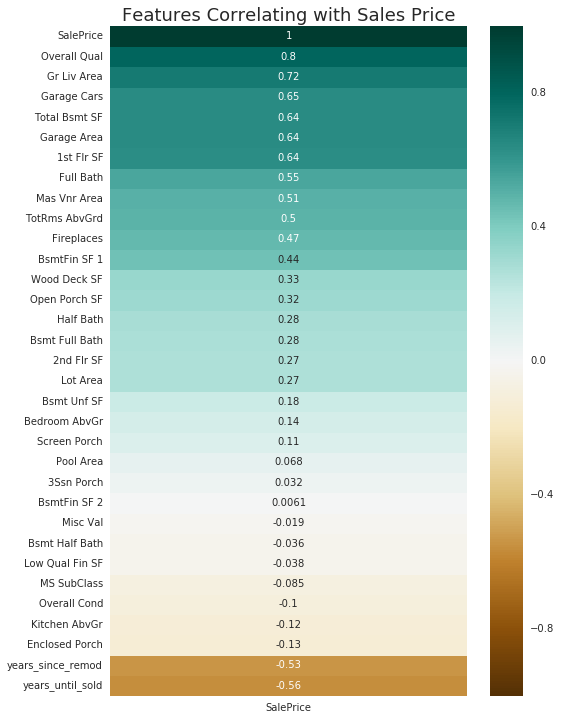

In [85]:
%matplotlib inline
numeric_df = transform_df.select_dtypes(include=numerics)
corr = numeric_df.corr()
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(corr[['SalePrice']].sort_values(by='SalePrice', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Sales Price', fontdict={'fontsize':18});

In [86]:
# Let's only keep columns with a correlation coefficient of larger than 0.4
abs_corr_coeffs = numeric_df.corr()['SalePrice'].abs().sort_values()
transform_df = transform_df.drop(abs_corr_coeffs[abs_corr_coeffs < 0.4].index, axis = 1)

Which categorical columns should we keep?

In [87]:
## Create a list of column names from documentation that are *meant* to be categorical
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

* Which columns are currently numerical but need to be encoded as categorical instead (because the numbers don't have any semantic meaning)?

* If a categorical column has hundreds of unique values (or categories), should we keep it? When we dummy code this column, hundreds of columns will need to be added back to the data frame.

In [88]:
# check which nominal features are present in transformed dataframe
transform_cat_cols = []
for col in nominal_features:
    if col in transform_df.columns:
        transform_cat_cols.append(col)

transform_cat_cols

['MS Zoning',
 'Street',
 'Land Contour',
 'Lot Config',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Foundation',
 'Heating',
 'Central Air']

In [89]:
# how many unique values in each categorical column?
cat_unique_counts = transform_df[transform_cat_cols].nunique().sort_values(ascending = False)
cat_unique_counts

Neighborhood    28
Exterior 2nd    17
Exterior 1st    16
Condition 1      9
Roof Matl        8
House Style      8
Condition 2      8
MS Zoning        7
Heating          6
Foundation       6
Roof Style       6
Bldg Type        5
Lot Config       5
Land Contour     4
Central Air      2
Street           2
dtype: int64

In [90]:
# arbitrary cutoff of 10 unique values (to be able to check against solution)
cat_unique_counts_above_10 = cat_unique_counts[cat_unique_counts > 10]
transform_df = transform_df.drop(cat_unique_counts_above_10.index, axis = 1)
transform_df.columns

Index(['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Roof Style', 'Roof Matl',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation',
       'BsmtFin SF 1', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       '1st Flr SF', 'Gr Liv Area', 'Full Bath', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Garage Cars',
       'Garage Area', 'Paved Drive', 'SalePrice', 'years_since_remod',
       'years_until_sold'],
      dtype='object')

In [91]:
# select just the remaining text columns and convert to categorical

text_cols = transform_df.select_dtypes(include=['object'])
for col in text_cols:
    transform_df[col] = transform_df[col].astype('category')
    dummies = pd.get_dummies(transform_df[col])
    transform_df = pd.concat([transform_df, dummies], axis = 1)
    transform_df = transform_df.drop(col, axis = 1)

transform_df.head(5)

,Overall Qual,Mas Vnr Area,BsmtFin SF 1,Total Bsmt SF,1st Flr SF,Gr Liv Area,Full Bath,TotRms AbvGrd,Fireplaces,Garage Cars,...,Maj2,Min1,Min2,Mod,Sal,Sev,Typ,N,P,Y
0,6,112.0,639.0,1080.0,1656,1656,1,7,2,2.0,...,0,0,0,0,0,0,1,0,1,0
1,5,0.0,468.0,882.0,896,896,1,5,0,1.0,...,0,0,0,0,0,0,1,0,0,1
2,6,108.0,923.0,1329.0,1329,1329,1,6,0,1.0,...,0,0,0,0,0,0,1,0,0,1
3,7,0.0,1065.0,2110.0,2110,2110,2,8,2,2.0,...,0,0,0,0,0,0,1,0,0,1
4,5,0.0,791.0,928.0,928,1629,2,6,1,2.0,...,0,0,0,0,0,0,1,0,0,1


In [108]:
# update select_features()

def transform_features(df):
    # Drop any columns with 5% or more missing values
    perc_missing_values = (df.isnull().sum()) / len(df) * 100
    clean_values = perc_missing_values[perc_missing_values < 5]
    df = df[clean_values.index]
    # Drop any text columns with 1 or more missing values
    missing_text = df.select_dtypes(include=['object'])
    missing_text_columns = missing_text_count[missing_text_count > 0].index
    df = df.drop(missing_text_columns, axis = 1)
    # Fill in with the most common value in numerical columns that have missing values
    num_missing = df.select_dtypes(include=numerics).isnull().sum()
    cols = num_missing[num_missing > 0].index
    for col in cols: 
        df[col] = df[col].fillna(df[col].mode()[0])
    # add years between sold & built/remodeled & remove corrupted data and useless columns
    df['years_since_remod'] = df['Yr Sold'] - df['Year Remod/Add'] 
    df['years_until_sold']  = df['Yr Sold'] - df['Year Built'] 
    df = df.drop([2180,2181,1702], axis = 0)
    df = df.drop(["Year Built", "Year Remod/Add"], axis = 1)
    # drop columns that aren't useful for ML or leak info about final sale
    df = df.drop(["PID", "Order","Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)
    return df

def select_features(df, coeff_threshold=0.4, uniq_threshold=10):
    # generate a correlation matrics for numeric values
    numeric_df = df.select_dtypes(include=numerics)
    corr = numeric_df.corr()
    abs_corr_coeffs = numeric_df.corr()['SalePrice'].abs().sort_values()
    # drop columns with a correlation inferior to the threshold
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs < coeff_threshold].index, axis = 1)
    
    # convert select nominal features to categories with dummy variables
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    cat_cols = []
    for col in nominal_features:
        if col in df.columns:
            cat_cols.append(col)
    cat_unique_counts = df[cat_cols].nunique()
    cat_unique_counts_above_10 = cat_unique_counts[cat_unique_counts > uniq_threshold]
    df = df.drop(cat_unique_counts_above_10.index, axis = 1)
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
        dummies = pd.get_dummies(df[col])
        df = pd.concat([df, dummies], axis = 1)
        df = df.drop(col, axis = 1)
    return df

def train_and_test(df, k=0):
    numeric_df = df.select_dtypes(include=numerics)
    features = numeric_df.columns.drop('SalePrice')
    target = ['SalePrice']
    lr = LinearRegression()
    # perform hold out validation if k is equal to 0
    if k == 0:
        # split the df in train and test data sets
        train = df.iloc[:1460]
        test = df.iloc[1460:]
        # train the model on train data set
        lr.fit(train[features], train[target])
        # test predictions on test data set
        test_predictions = lr.predict(test[features])
        # measure error between predictions and observations
        test_mse = mean_squared_error(test_predictions, test[target])
        rmse = np.sqrt(test_mse)
        return rmse
    
    # perform 2 fold cross validation if k is equal to 1
    if k == 1:
        # shuffle the ordering of rows in the df
        shuffled_df = df.sample(frac=1)
        
        # split the df in two folds
        fold_one = df.iloc[:1460]
        fold_two = df.iloc[1460:]
        
        # train on fold one and test on fold two
        lr.fit(fold_one[features], fold_one[target])
        fold_one_predictions = lr.predict(fold_two[features])
        fold_one_mse = mean_squared_error(fold_one_predictions, fold_two[target])
        fold_one_rmse = np.sqrt(fold_one_mse)
        
        # train on fold two and test on fold one
        lr.fit(fold_two[features], fold_two[target])
        fold_two_predictions = lr.predict(fold_one[features])
        fold_two_mse = mean_squared_error(fold_two_predictions, fold_one[target])
        fold_two_rmse = np.sqrt(fold_two_mse)
        
        # print the 2 rmses and average them
        avg_rmse = np.mean([fold_one_rmse, fold_two_rmse])
        print(fold_one_rmse)
        print(fold_two_rmse)
        return avg_rmse
        
    # perform k-fold cross validation if k is not equal to 1 or 0
    elif k > 1:
        # split the df in K folds
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        # for each fold train the data on K-1 number of folds and test on 1 fold 
        for train_index, test_index in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            # train on K-1 folds
            lr.fit(train[features], train[target])
            # test on remaining fold
            test_predictions = lr.predict(test[features])
            test_mse = mean_squared_error(test_predictions, test[target])
            rmse = np.sqrt(test_mse)
            rmse_values.append(rmse)
        # print and average each rmse
        print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        return avg_rmse
    else:
        print("Error: enter a positive k value")
        

transform_df = transform_features(houses)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df, k = 10)
rmse

[30539.7392177168, 32762.941628046647, 29720.06632155188, 33670.314251408265, 35078.207193115806, 28587.148562324746, 28827.74092925013, 26820.406761042705, 50704.24512886942, 32026.798189401496]


32873.76081827279